In [1]:
# Imports
from os import makedirs
from os.path import join
import joblib
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.auto import tqdm
import pandas as pd
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from nltk.corpus import wordnet as wn
import annoy
from umap import UMAP
from sklearn.decomposition import PCA

import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.express as px
import plotly.graph_objects as go

# Directory constants
topological_data_analysis_data_dir = "data"
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys
sys.path.append(root_code_dir)

from utils import get_model_checkpoint_filepaths, pairwise_cosine_distances, words_to_vectors
from word_embeddings.word2vec import load_model_training_output
from vis_utils import plot_word_vectors
from topological_data_analysis.tda_utils import plot_persistence_diagram, tps, generate_points_in_spheres

# Prepare data

In [2]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(word2vec_training_dir, "word2vec_enwiki_sept_2020_word2phrase"),
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights = w2v_training_output["last_embedding_weights"]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

In [3]:
# Normalize word embeddings
last_embedding_weights_normalized = last_embedding_weights / np.linalg.norm(last_embedding_weights, axis=1).reshape(-1, 1)

In [4]:
# Load SemEval data
semeval_2010_14_word_senses = joblib.load(
    join(topological_data_analysis_data_dir, "semeval_2010_14_word_senses.joblib")
)

In [5]:
annoy_index = annoy.AnnoyIndex(f=last_embedding_weights.shape[1], metric="euclidean")
annoy_index.load(
    fn=join(word2vec_ann_indices_dir, "word2vec_enwiki_annoy_index.ann"),
    prefault=True
)

True

In [106]:
point_in_each_sphere = 10000
num_total_sphere_points = 2 * point_in_each_sphere
sphere_points, sphere_point_labels = generate_points_in_spheres(
    num_points=point_in_each_sphere,
    sphere_dimensionality=4,
    sphere_means=(0, 0.99),
    space_dimensionality=300,
    random_state=rng_seed
)

In [109]:
visualize_spheres = True
if visualize_spheres:
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=sphere_points[:, 0],
        y=sphere_points[:, 1],
        z=sphere_points[:, 2],
        mode='markers',
        marker={
            "color": sphere_point_labels,
        }
    ))
    fig.show()

# Topolocial polysemy

In [111]:
tps_neighbourhood_size = 50

## TPS for 100 SemEval target words

Neighbourhood size: 50


  0%|          | 0/100 [00:00<?, ?it/s]

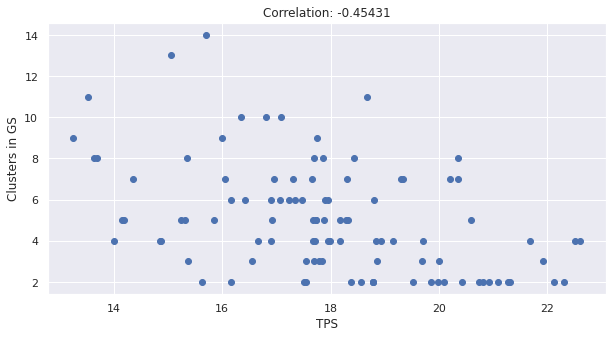

In [38]:
# Compute TPS for 100 SemEval target words
semeval_target_word_tps_scores = {}

semeval_gs_clusters = list(semeval_2010_14_word_senses["all"].values())
num_semeval_words = len(semeval_gs_clusters)

print(f"Neighbourhood size: {tps_neighbourhood_size}")

# Compute TPS scores
semeval_tps_scores = np.zeros(num_semeval_words)
semeval_tps_persistence_diagrams = []
for i, (semeval_target_word, semeval_target_word_clusters) in enumerate(tqdm(semeval_2010_14_word_senses["all"].items())):
    tps_score, tps_persistence_diagram = tps(
        target_word=semeval_target_word,
        word_embeddings=last_embedding_weights,
        words_vocabulary=None,
        word_to_int=word_to_int,
        neighbourhood_size=tps_neighbourhood_size,
        word_embeddings_normalized=last_embedding_weights_normalized,
        word_embeddings_pairwise_dists=None,
        annoy_index=annoy_index,
        return_persistence_diagram=True
    )
    semeval_tps_scores[i] = tps_score
    semeval_tps_persistence_diagrams.append(tps_persistence_diagram)

# Compute correlation
semeval_tps_score_gs_correlation, _ = pearsonr(
    x=semeval_tps_scores,
    y=semeval_gs_clusters
)

# Plot TPS scores to GS
plt.figure(figsize=(10, 5))
plt.scatter(
    x=semeval_tps_scores,
    y=semeval_gs_clusters
)
plt.xlabel("TPS")
plt.ylabel("Clusters in GS")
plt.title(f"Correlation: {semeval_tps_score_gs_correlation:.5f}")
plt.show()

## Persistence diagrams of high/low TPS words

In [39]:
# Sort words by TPS score
semeval_tps_scores_sorted_indices = np.argsort(semeval_tps_scores)[::-1]
semeval_tps_scores_sorted = semeval_tps_scores[semeval_tps_scores_sorted_indices]
semeval_target_words_sorted = np.array(list(semeval_2010_14_word_senses["all"].keys()))[semeval_tps_scores_sorted_indices]
semeval_tps_persistence_diagrams_sorted = np.array(semeval_tps_persistence_diagrams, dtype="object")[semeval_tps_scores_sorted_indices]

top_k_words = 3
top_k_semeval_tps_words = [
    (i, semeval_target_words_sorted[i], semeval_tps_scores_sorted[i], semeval_gs_clusters[i])
    for i in range(top_k_words)
]
bottom_k_semeval_tps_words = [
    (i, semeval_target_words_sorted[i], semeval_tps_scores_sorted[i], semeval_gs_clusters[i])
    for i in range(num_semeval_words - top_k_words, num_semeval_words)
]
top_bottom_k_semeval_tps_words = [*top_k_semeval_tps_words, *bottom_k_semeval_tps_words]
top_bottom_k_semeval_tps_word_ints = [word_to_int[word] for _, word, _, _ in top_bottom_k_semeval_tps_words]
print(f"Top {top_k_words} SemEval TPS words\n", top_k_semeval_tps_words)
print()
print(f"Bottom {top_k_words} SemEval TPS words\n", bottom_k_semeval_tps_words)

Top 3 SemEval TPS words
 [(0, 'threat', 22.605424576490414, 3), (1, 'legislation', 22.498374565355483, 3), (2, 'assemble', 22.305263919475262, 2)]

Bottom 3 SemEval TPS words
 [(97, 'note', 13.632594166178295, 4), (98, 'field', 13.52820188436635, 4), (99, 'class', 13.252730593193567, 5)]


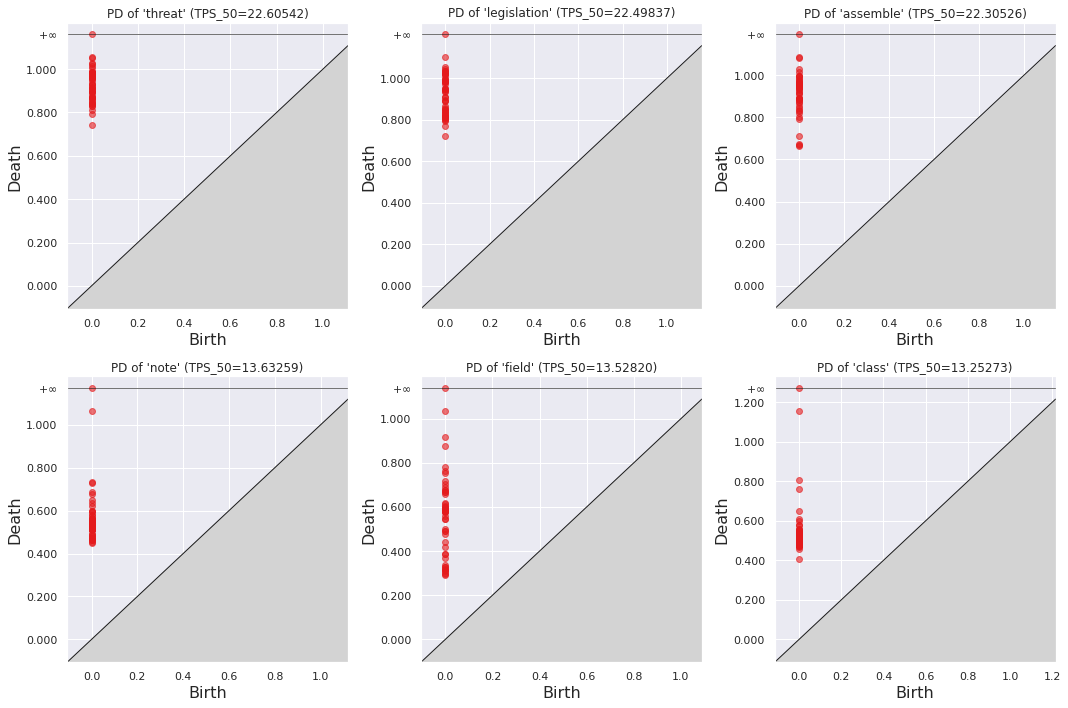

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5 * 3, 5 * 2))
for (i, word, word_tps, _), ax in zip(top_bottom_k_semeval_tps_words, axes.ravel()):
    gd.plot_persistence_diagram(semeval_tps_persistence_diagrams_sorted[i], axes=ax)
    ax.set_title(f"PD of '{word}' (TPS_{tps_neighbourhood_size}={word_tps:.5f})")
plt.tight_layout()
plt.show()

## Neighbouring words of high/low TPS words

In [41]:
top_bottom_k_semeval_tps_vocab_word_ints = []
top_bottom_k_semeval_tps_word_neighbourhood = {}
for _, word, _, _ in top_bottom_k_semeval_tps_words:
    word_int = word_to_int[word]
    neighbouring_word_ints = annoy_index.get_nns_by_item(i=word_int, n=tps_neighbourhood_size + 1)[1:]
    top_bottom_k_semeval_tps_word_neighbourhood[word_int] =  neighbouring_word_ints
    top_bottom_k_semeval_tps_vocab_word_ints.extend([word_int, *neighbouring_word_ints])

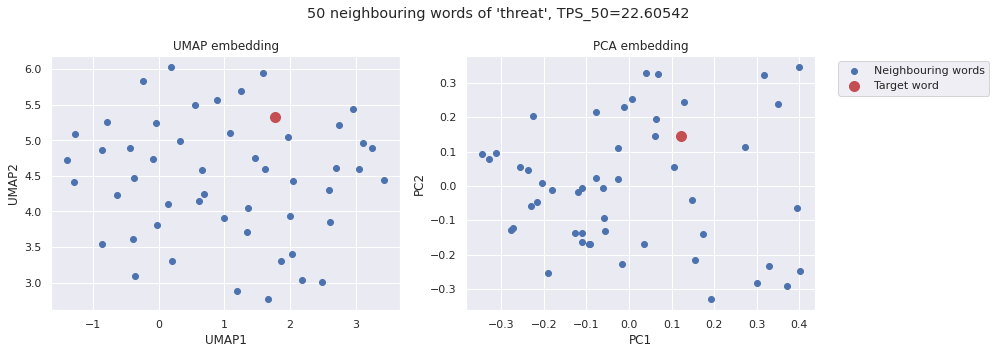

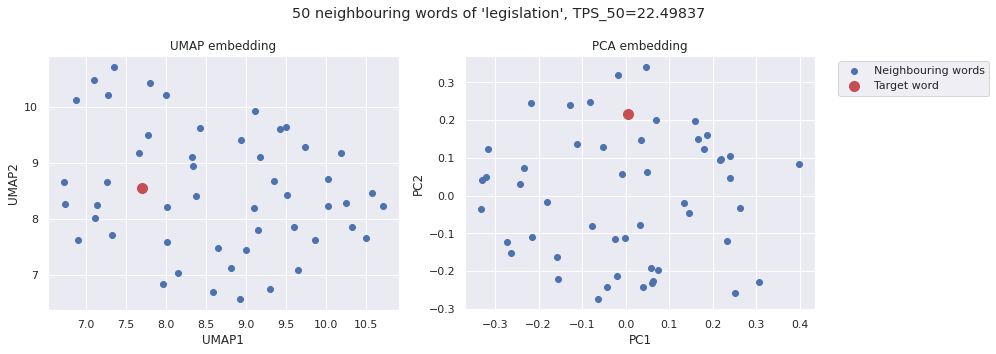

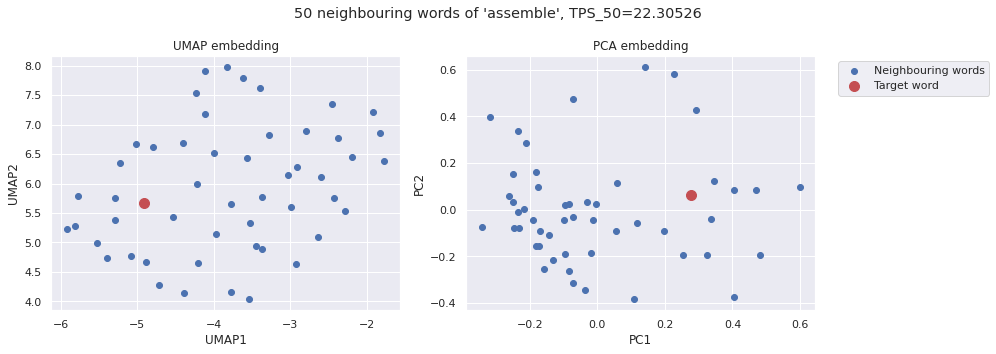

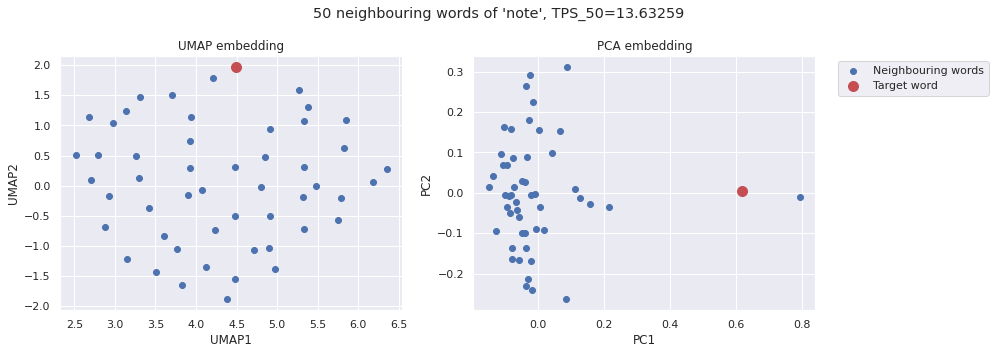

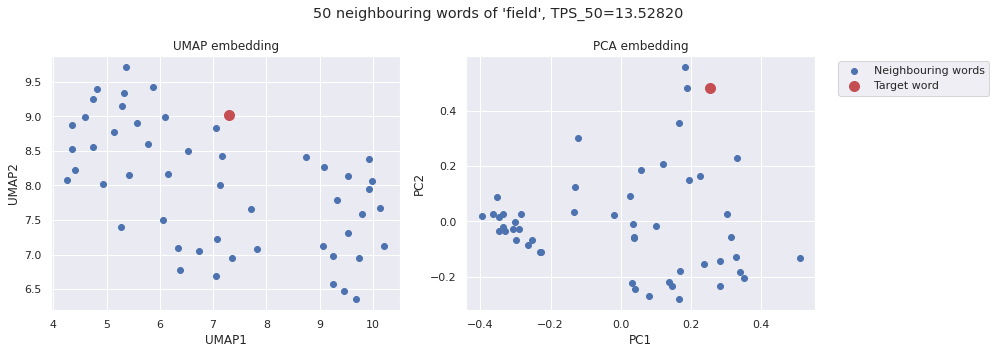

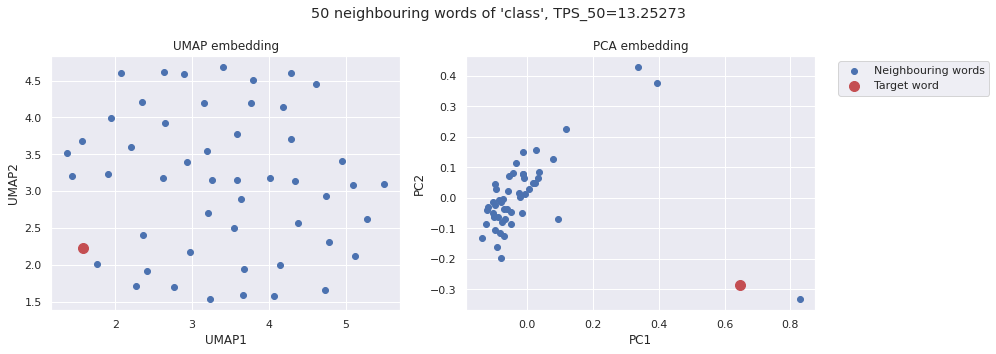

In [62]:
for _, word, word_tps, _ in top_bottom_k_semeval_tps_words:
    
    # Find neighbouring word ints
    word_int = word_to_int[word]
    neighbouring_word_ints = annoy_index.get_nns_by_item(i=word_int, n=tps_neighbourhood_size + 1)[1:]
    
    # Compute UMAP and PCA embedding of neighbouring words
    embedders = [(UMAP, "UMAP1", "UMAP2"), (PCA, "PC1", "PC2")]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7 * 2, 5))
    for (embedder, x_label, y_label), ax in zip(embedders, axes.ravel()):
        tps_word_embeddings_transformed = embedder(
            n_components=2,
            random_state=rng_seed,
        ).fit_transform(
            last_embedding_weights_normalized[[word_int, *neighbouring_word_ints]]
        )

        ax.scatter(
            tps_word_embeddings_transformed[1:, 0],
            tps_word_embeddings_transformed[1:, 1],
            c="b",
            label="Neighbouring words"
        )
        ax.scatter(
            tps_word_embeddings_transformed[0, 0],
            tps_word_embeddings_transformed[0, 1],
            c="r",
            s=100,
            label="Target word"
        )
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f"{embedder.__name__} embedding")
    plt.suptitle(f"{tps_neighbourhood_size} neighbouring words of '{word}', TPS_{tps_neighbourhood_size}={word_tps:.5f}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()

## TPS of points in 4-dimensional spheres

In [114]:
# Find indices of points
point_indices_in_sphere_1 = np.where(sphere_point_labels == 0)[0]
point_indices_in_sphere_2 = np.where(sphere_point_labels == 1)[0]
point_indices_intersect = np.where(sphere_point_labels == 2)[0]

In [115]:
point_to_int = {i: i for i in range(num_total_sphere_points)}
sphere_points_normalized = sphere_points / np.linalg.norm(sphere_points, axis=1).reshape(-1, 1)
tps_scores_point_in_spheres = []
for point_index in tqdm(range(num_total_sphere_points)):
    tps_score, tps_persistence_diagram = tps(
        target_word=point_index,
        word_embeddings=sphere_points,
        word_embeddings_normalized=sphere_points_normalized,
        words_vocabulary=None,
        word_to_int=point_to_int,
        neighbourhood_size=tps_neighbourhood_size,
        return_persistence_diagram=True
    )
    tps_scores_point_in_spheres.append(tps_score)
tps_scores_point_in_spheres = np.array(tps_scores_point_in_spheres)

  0%|          | 0/20000 [00:00<?, ?it/s]

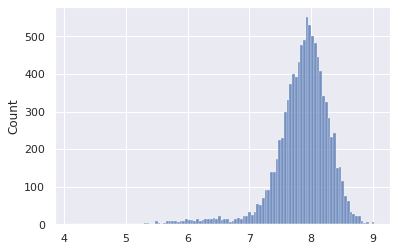

Mean: 7.849600899088725


In [122]:
sns.histplot(tps_scores_point_in_spheres[point_indices_in_sphere_1])
plt.show()
print("Mean:", np.mean(tps_scores_point_in_spheres[point_indices_in_sphere_1]))

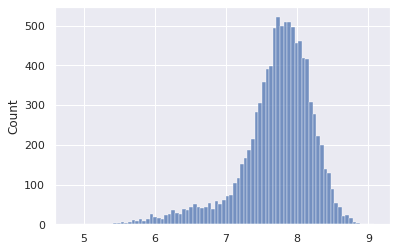

Mean: 7.711025495337896


In [123]:
sns.histplot(tps_scores_point_in_spheres[point_indices_in_sphere_2])
plt.show()
print("Mean:", np.mean(tps_scores_point_in_spheres[point_indices_in_sphere_2]))

In [119]:
tps_scores_point_in_spheres[point_indices_intersect]

array([7.9060326])